# "MovieLens Recommender Sysyem: Item-Based Collaborative Filtering"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from scipy.stats import spearmanr
from math import sqrt
from sklearn.neighbors import NearestNeighbors


In [3]:
# Load Data
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MovieLens/User_ratings_For_Movie.csv')
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MovieLens/movies.csv')

## Data Cleaning

### Inspecting Data

In [4]:
print(ratings.head())
print(movies.head())

   userId  movieId  rating     timestamp
0       1        1     4.0  1.225735e+09
1       1      110     4.0  1.225865e+09
2       1      158     4.0  1.225734e+09
3       1      260     4.5  1.225735e+09
4       1      356     5.0  1.225735e+09
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [5]:
ratings.info()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125352 entries, 0 to 125351
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### Handling Missing Values

In [6]:
# Check for missing values (NaN or null values)
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    1
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


### Merge Datasets

In [7]:
df = pd.merge(ratings, movies, on='movieId')
df.head(20)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,1.225735e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,8.358160e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,9.745180e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,1.430666e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,8.625007e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,14,1,2.5,1.311533e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,21,1,3.0,1.172695e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,24,1,4.5,1.062944e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,32,1,3.5,1.431434e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9,35,1,4.0,1.119980e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125352 entries, 0 to 125351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
 4   title      125352 non-null  object 
 5   genres     125352 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 6.7+ MB


In [9]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    1
title        0
genres       0
dtype: int64

### Drop Unused Columns

In [10]:
print(df['timestamp'].isnull().sum())

1


In [11]:
df = df.dropna(subset=['timestamp'])

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


<ipython-input-12-46962d8c04a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


<ipython-input-13-48bf24d508a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


In [14]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [15]:
print(df.dtypes)

userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
title                object
genres               object
dtype: object


## EDA

### Descriptive Statistics

In [16]:
df.describe()

,userId,movieId,rating
count,125351.000000,125351.000000,125351.000000
mean,646.079896,27844.978453,3.584323
std,372.152625,48904.887953,1.049878
min,1.000000,1.000000,0.500000
25%,318.000000,1208.000000,3.000000
50%,624.000000,3168.000000,4.000000
75%,974.000000,40815.000000,4.500000
max,1293.000000,288269.000000,5.000000


In [17]:
# It counts the occurrences of each genre in the 'genres' column using value_counts() method.
df['genres'].value_counts()

Drama                                         7958
Comedy                                        7150
Comedy|Romance                                4122
Drama|Romance                                 3534
Action|Adventure|Sci-Fi                       3498
                                              ... 
Crime|Drama|Mystery|Romance                      1
Comedy|Mystery|Romance                           1
Drama|Fantasy|War                                1
Children|Documentary                             1
Adventure|Animation|Fantasy|Musical|Sci-Fi       1
Name: genres, Length: 976, dtype: int64

In [18]:
# Understanding the data
df.describe(include='all')

<ipython-input-18-a8cd5e172dee>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,userId,movieId,rating,timestamp,title,genres
count,125351.000000,125351.000000,125351.000000,125351,125351,125351
unique,NaN,NaN,NaN,107597,11036,976
top,NaN,NaN,NaN,2017-08-30 18:51:09,"Shawshank Redemption, The (1994)",Drama
freq,NaN,NaN,NaN,160,476,7958
first,NaN,NaN,NaN,1996-02-29 16:14:11,NaN,NaN
last,NaN,NaN,NaN,2023-07-20 07:26:24,NaN,NaN
mean,646.079896,27844.978453,3.584323,NaN,NaN,NaN
std,372.152625,48904.887953,1.049878,NaN,NaN,NaN
min,1.000000,1.000000,0.500000,NaN,NaN,NaN
25%,318.000000,1208.000000,3.000000,NaN,NaN,NaN


### Visualizing the Distribution

#### Normality Check

In [19]:
# Perform Anderson-Darling test on 'rating' column
anderson_test = stats.anderson(df['rating'], dist='norm')
print(f"Anderson-Darling Test statistic: {anderson_test.statistic}, critical values: {anderson_test.critical_values}")

# Interpretation of the output
if anderson_test.statistic > max(anderson_test.critical_values):
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data might be normal.")


Anderson-Darling Test statistic: 2731.1566854082484, critical values: [0.576 0.656 0.787 0.918 1.092]
Reject null hypothesis: Data is not normally distributed.


#### Histogram

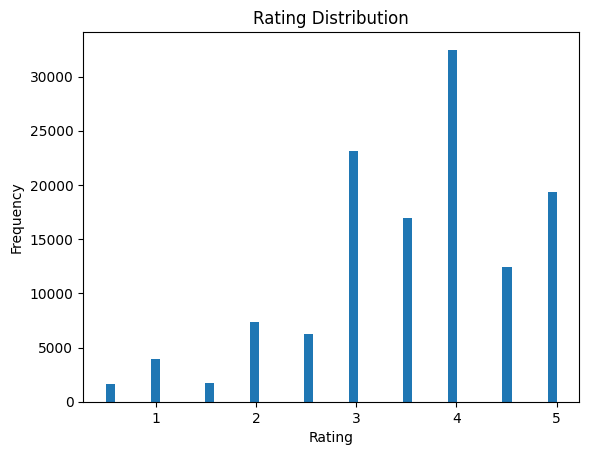

In [20]:
plt.hist(df['rating'], bins=50)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Boxplot

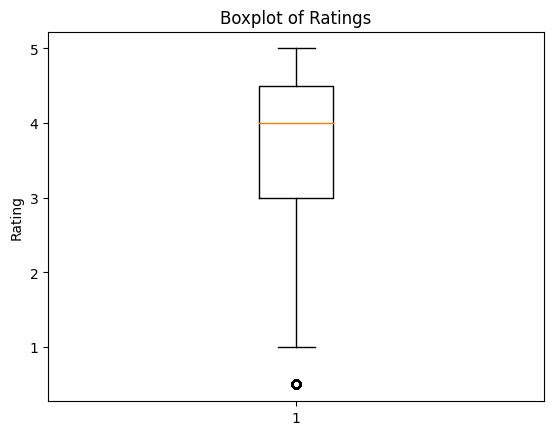

In [21]:
plt.boxplot(df['rating'])
plt.title('Boxplot of Ratings')
plt.ylabel('Rating')
plt.show()

The ratings go from 1 to 5. The box in the center of the plot contains the middle 50% of the ratings. The line in the middle of the box represents the median rating, which is 3. The whiskers extend out from the top and bottom of the box. They show the range of the rest of the data, excluding outliers. In this case, the whiskers extend to 1 at the bottom and 4 at the top. This means that there are some ratings that are lower than 1 or higher than 4, but not many. These are considered outliers and are plotted as individual points beyond the whiskers.

- The ratings mostly range from around
- The median rating appears to be around  indicating that half of the ratings are above  and half are below.
- There are a few outliers on the lower side, indicating that there are a few unusually low ratings compared to the rest of the data.
- There are no outliers on the higher side, so the highest ratings don't differ as much from the general dataset as the lowest ones do.

#### Correlation Matrix

<ipython-input-22-587d81ac2f94>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


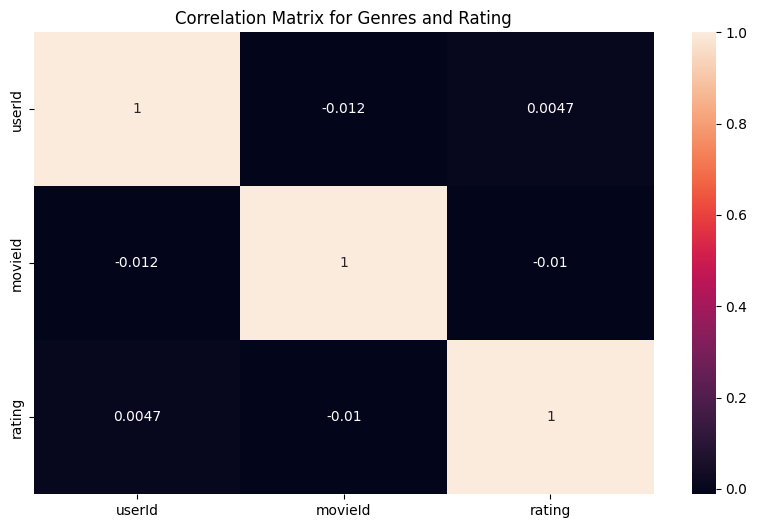

In [22]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Genres and Rating')
plt.show()

#### Data Distribution

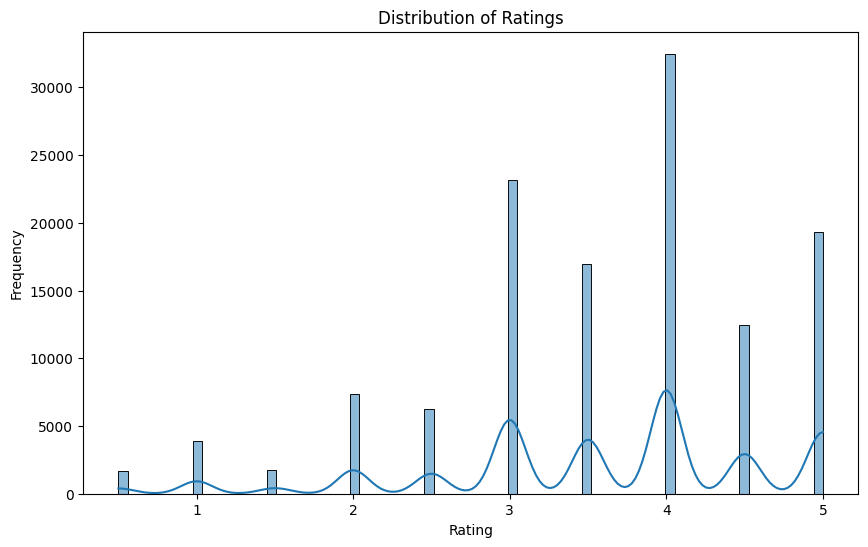

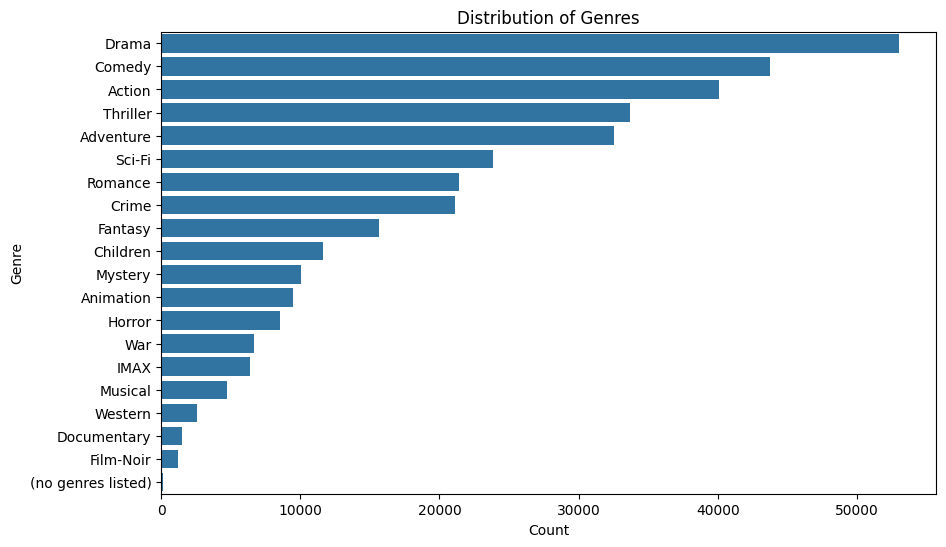

In [23]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Genres distribution
plt.figure(figsize=(10, 6))
genres = df['genres'].str.split('|').explode()
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

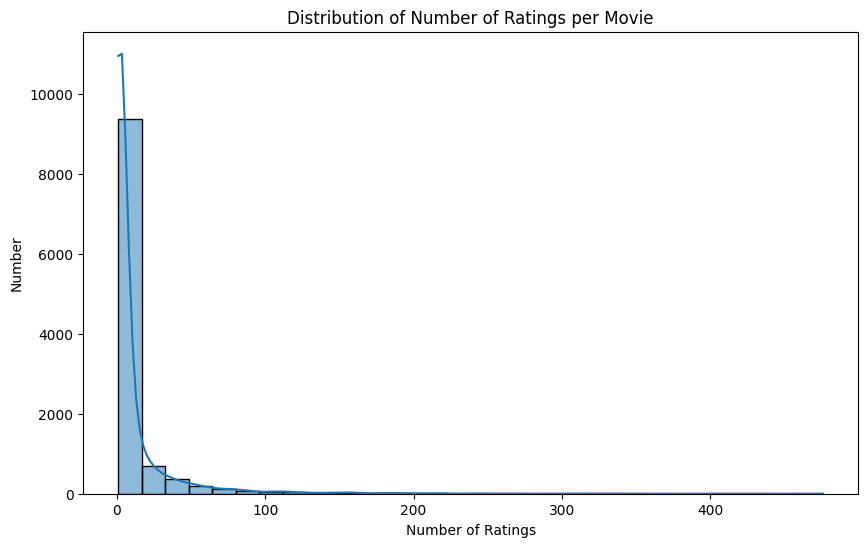

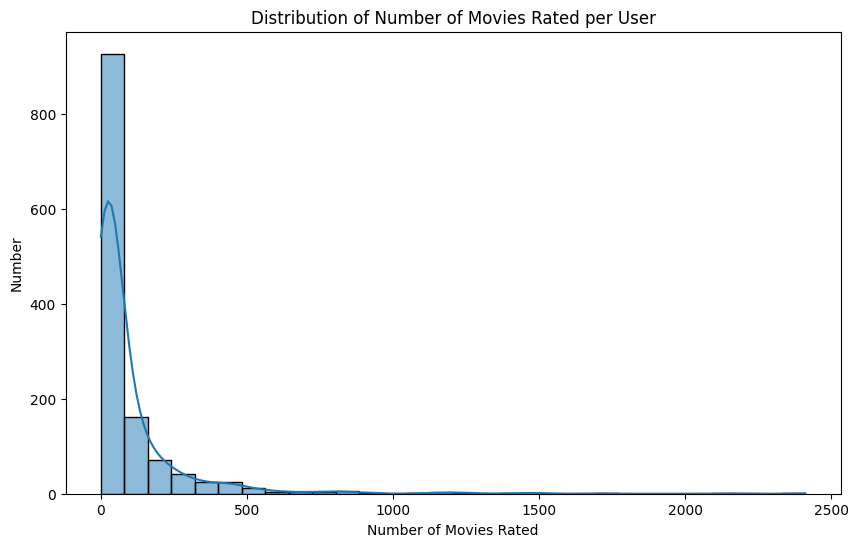

In [24]:
# Distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('movieId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number')
plt.show()

# Distribution of the number of movies rated per user
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('userId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Movies Rated per User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number')
plt.show()


### Encoding Categorical Variables

In [25]:
# Extract genres and perform one-hot encoding
df_genres = movies.set_index('movieId')['genres'].str.get_dummies(sep='|')


In [26]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Creating New Features

In [27]:
# Extracting the number of genres per movie as a new feature
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')))

In [28]:
df.head()

,userId,movieId,rating,timestamp,title,genres,num_genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5


In [29]:
# Correlation between 'rating' and 'num_genres'
spearman_corr, spearman_p_value = spearmanr(df['rating'], df['num_genres'])
print(f"Spearman's Correlation Coefficient: {spearman_corr}, P-value: {spearman_p_value}")

# Interpretation of Spearman's correlation
if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("There is a statistically significant positive correlation between 'rating' and 'num_genres'.")
    elif spearman_corr < 0:
        print("There is a statistically significant negative correlation between 'rating' and 'num_genres'.")
    else:
        print("There is a statistically significant but no linear correlation between 'rating' and 'num_genres'.")
else:
    print("There is no statistically significant correlation between 'rating' and 'num_genres'.")


Spearman's Correlation Coefficient: 0.0031106949888586475, P-value: 0.27075241756247964
There is no statistically significant correlation between 'rating' and 'num_genres'.


## Model Implementation


### 1. Data Preparation

In [30]:
# One-hot encode genres
df['genres_list'] = df['genres'].str.split('|') #Splits the 'genres' column into lists of genres.

#explodes the lists in the 'genres_list' column into separate rows.
#Then it converts the categorical variable into dummy variables and groups the dummy variables
genres_encoded = df['genres_list'].explode().str.get_dummies().groupby(level=0).sum()


#### Creating Interaction Features

In [31]:
# Initialize a list to collect the new interaction DataFrames
interaction_columns = []

# Generate interaction features by multiplying pairs of one-hot encoded genre columns together
genre_columns = genres_encoded.columns
for i in range(len(genre_columns)):
    for j in range(i+1, len(genre_columns)):
        interaction_feature_name = f"{genre_columns[i]}_{genre_columns[j]}"
        # Instead of inserting each column into the DataFrame, store it in the list
        interaction_columns.append(genres_encoded[genre_columns[i]] * genres_encoded[genre_columns[j]].rename(interaction_feature_name))

# Concatenate all interaction columns at once before concatenating with the original DataFrame
interaction_features = pd.concat(interaction_columns, axis=1)
genres_encoded = pd.concat([genres_encoded, interaction_features], axis=1)


In [70]:
df.head()

,userId,movieId,rating,timestamp,title,genres,num_genres,genres_list,is_target_genre,genre_popularity_score,genre_rarity_score
11916,490,265,5.0,1996-02-29 16:14:11,Like Water for Chocolate (Como agua para choco...,Drama|Fantasy|Romance,3,"[Drama, Fantasy, Romance]",0,0.681624,1.318376
12986,490,315,1.0,1996-02-29 16:48:44,"Specialist, The (1994)",Action|Drama|Thriller,3,"[Action, Drama, Thriller]",0,1.047190,0.952810
12628,490,296,5.0,1996-02-29 16:48:44,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4,"[Comedy, Crime, Drama, Thriller]",1,0.976688,1.523312
23599,490,319,3.0,1996-02-29 16:48:44,Shallow Grave (1994),Comedy|Drama|Thriller,3,"[Comedy, Drama, Thriller]",1,0.992924,1.007076
14942,490,380,4.0,1996-03-01 00:00:00,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,5,"[Action, Adventure, Comedy, Romance, Thriller]",1,0.957101,2.042899


### Prepare Classification Labels:
Creating a binary label for the target genre (Action).

In [65]:
# Choose a target genre for classification
target_genre = 'Comedy'  # Example, choose accordingly
# Create binary labels for the target genre
df['is_target_genre'] = df['genres_list'].apply(lambda genres: 1 if target_genre in genres else 0)


#### Calculate Genre Popularity

In [34]:
# Calculate genre popularity as the sum of movies in each genre
genre_popularity = genres_encoded.sum(axis=0).sort_values(ascending=False)

# Normalize genre popularity to get a score between 0 and 1
genre_popularity = genre_popularity / genre_popularity.max()


#### Calculate Genre Rarity

In [35]:
# Calculate genre rarity as the inverse of popularity
genre_rarity = 1 - genre_popularity

#### Add Popularity and Rarity Scores to Each Movie

In [36]:
# For each movie, calculate an average popularity score based on its genres
df['genre_popularity_score'] = genres_encoded.dot(genre_popularity) / df['num_genres']

# Similarly, calculate an average rarity score
df['genre_rarity_score'] = genres_encoded.dot(genre_rarity) / df['num_genres']

#### Full Code Integration

In [37]:
# Calculate genre popularity and rarity
genre_popularity = genres_encoded.sum(axis=0).sort_values(ascending=False)
genre_popularity = genre_popularity / genre_popularity.max()  # Normalize
genre_rarity = 1 - genre_popularity  # Calculate rarity as inverse of popularity

# Add average popularity and rarity scores for each movie's genres
df['genre_popularity_score'] = genres_encoded.dot(genre_popularity) / df['num_genres']
df['genre_rarity_score'] = genres_encoded.dot(genre_rarity) / df['num_genres']


### Sorting Dataframe by Timestamp

In [38]:
df = df.sort_values(by='timestamp')


### Splitting Based on Timestamp

In [39]:
# Determine the indices for splitting
train_idx = int(len(df) * 0.6)
validation_idx = int(len(df) * 0.8)

# Split the data
train = df.iloc[:train_idx]
validation = df.iloc[train_idx:validation_idx]
test = df.iloc[validation_idx:]


In [40]:
# Show the shapes of the splits
train.shape, validation.shape, test.shape

((75210, 11), (25070, 11), (25071, 11))

In [41]:
# Prepare data for similarity computation for item similarity based on user ratings (User-Item Matrix)
# Any missing values (if a user hasn't rated a particular movie) are filled with 0.
pivot_table_train = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)


In [71]:
pivot_table_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,119800,119802,120290,120635,121235,121255,126595,127315,128488,128600
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Ensure train DataFrame has 'movieId' as index or use it for filtering directly
train_indexed = train.set_index('movieId')

# Find common movieIds between genres_encoded and train
# This ensures that only movies present in both datasets are considered for similarity computation.
common_movieIds = genres_encoded.index.intersection(train_indexed.index)

# Filter genres_encoded to include only common movieIds
# This ensures that we're only considering genres encoded information for movies that have ratings data available.
genres_encoded_train = genres_encoded.loc[common_movieIds]


In [45]:
####### COSINE Calculations
# Compute item similarity matrix based on ratings
item_similarity_cosine = cosine_similarity(pivot_table_train.T) # pivot_table_train.T = Transposed pivot_table_train matrix
item_similarity_df_cosine = pd.DataFrame(item_similarity_cosine, index=pivot_table_train.columns, columns=pivot_table_train.columns)

# Proceed with the similarity computation
genre_similarity_cosine = cosine_similarity(genres_encoded_train)
genre_similarity_df_cosine = pd.DataFrame(genre_similarity_cosine, index=common_movieIds, columns=common_movieIds)

# Normalize and combine the similarity matrices using min-max normalization
item_similarity_df_cosine = (item_similarity_df_cosine - item_similarity_df_cosine.min()) / (item_similarity_df_cosine.max() - item_similarity_df_cosine.min())
genre_similarity_df_cosine = (genre_similarity_df_cosine - genre_similarity_df_cosine.min()) / (genre_similarity_df_cosine.max() - genre_similarity_df_cosine.min())
combined_similarity_df_cosine = (item_similarity_df_cosine + genre_similarity_df_cosine) / 2



In [46]:
######## MANHATTAN Calculations

# Compute item similarity matrix based on ratings using Manhattan distance
item_similarity_manhattan = manhattan_distances(pivot_table_train.T)
item_similarity_df_manhattan = pd.DataFrame(item_similarity_manhattan, index=pivot_table_train.columns, columns=pivot_table_train.columns)

# Compute genre similarity matrix using Manhattan distance
genre_similarity_manhattan = manhattan_distances(genres_encoded_train)
genre_similarity_df_manhattan = pd.DataFrame(genre_similarity_manhattan, index=common_movieIds, columns=common_movieIds)

# Normalize and combine the similarity matrices using min-max normalization
item_similarity_df_manhattan = (item_similarity_df_manhattan - item_similarity_df_manhattan.min()) / (item_similarity_df_manhattan.max() - item_similarity_df_manhattan.min())
genre_similarity_df_manhattan = (genre_similarity_df_manhattan - genre_similarity_df_manhattan.min()) / (genre_similarity_df_manhattan.max() - genre_similarity_df_manhattan.min())
combined_similarity_df_manhattan = (item_similarity_df_manhattan + genre_similarity_df_manhattan) / 2


In [47]:
def compute_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [48]:
def predict_rating(user_id, item_id, k, user_item_matrix, combined_similarity_df_cosine, combined_similarity_df_manhattan, distance_metric):
    if item_id in user_item_matrix.columns:
        # Choose the combined similarity matrix based on the distance metric
        if distance_metric == 'cosine':
            combined_similarity_df = combined_similarity_df_cosine
        elif distance_metric == 'manhattan':
            combined_similarity_df = combined_similarity_df_manhattan
        else:
            raise ValueError("Invalid distance metric. Choose 'cosine' or 'manhattan'.")

        # Ensure the similarity matrix includes the target item_id
        if item_id not in combined_similarity_df.columns:
            return np.nan

        # Get the k most similar items to the target item
        similar_items = combined_similarity_df[item_id].sort_values(ascending=False)[1:k+1]

        # Check if user_id exists in the user_item_matrix
        if user_id in user_item_matrix.index:
            # Filter similar_items to include only those present in user_item_matrix.columns
            similar_items = similar_items[similar_items.index.isin(user_item_matrix.columns)]

            # Retrieve user's ratings for these similar items, ensuring only valid columns are accessed
            user_ratings = user_item_matrix.loc[user_id, similar_items.index].dropna()

            # Calculate the predicted rating based on the weighted average of ratings for the similar items
            if not user_ratings.empty and similar_items.loc[user_ratings.index].sum() > 0:
                prediction = np.dot(user_ratings, similar_items.loc[user_ratings.index]) / similar_items.loc[user_ratings.index].sum()
            else:
                prediction = np.nan
        else:
            prediction = np.nan
    else:
        prediction = np.nan
    return prediction


In [49]:
def grid_search(train_data, k_values, distance_metrics, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_k = None
    best_distance_metric = None
    best_rmse = float('inf')

    for k in k_values:
        for distance_metric in distance_metrics:
            rmse_scores = []
            for train_index, val_index in kf.split(train_data):
                train_fold = train_data.iloc[train_index]
                val_fold = train_data.iloc[val_index]

                user_item_matrix_train = train_fold.pivot(index='userId', columns='movieId', values='rating').fillna(0)

                # Find common movie IDs between the user-item matrix and the genres_encoded DataFrame
                common_movie_ids = user_item_matrix_train.columns.intersection(genres_encoded.index)

                # Filter both the user-item matrix and the genres_encoded DataFrame to include only common movie IDs
                user_item_matrix_train_filtered = user_item_matrix_train[common_movie_ids]
                genres_encoded_train_filtered = genres_encoded.loc[common_movie_ids]

                # Adjust the conversion to DataFrame for item_similarity_matrix and genre_similarity_matrix
                if distance_metric == 'cosine':
                    item_similarity_matrix = pd.DataFrame(cosine_similarity(user_item_matrix_train_filtered.T),
                                                          index=common_movie_ids,
                                                          columns=common_movie_ids)
                    genre_similarity_matrix = pd.DataFrame(cosine_similarity(genres_encoded_train_filtered),
                                                           index=common_movie_ids,
                                                           columns=common_movie_ids)
                elif distance_metric == 'manhattan':
                    item_similarity_matrix = pd.DataFrame(manhattan_distances(user_item_matrix_train_filtered.T),
                                                          index=common_movie_ids,
                                                          columns=common_movie_ids)
                    genre_similarity_matrix = pd.DataFrame(manhattan_distances(genres_encoded_train_filtered),
                                                           index=common_movie_ids,
                                                           columns=common_movie_ids)
                else:
                    raise ValueError("Invalid distance metric. Choose 'cosine' or 'manhattan'.")

                val_rmse = []
                for index, row in val_fold.iterrows():
                    user_id = row['userId']
                    item_id = row['movieId']
                    actual_rating = row['rating']
                    predicted_rating = predict_rating(user_id, item_id, k, user_item_matrix_train_filtered,
                                                      item_similarity_matrix, genre_similarity_matrix, distance_metric)
                    if not np.isnan(predicted_rating):
                        val_rmse.append(compute_rmse([actual_rating], [predicted_rating]))

                if val_rmse:
                    rmse_scores.append(np.mean(val_rmse))

            avg_rmse = np.mean(rmse_scores)
            # Print the RMSE for the current combination of k and distance metric
            print(f"RMSE for k={k}, distance metric='{distance_metric}': {avg_rmse}")

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_k = k
                best_distance_metric = distance_metric

    return best_k, best_distance_metric


In [50]:
# Define a range of k values and distance metrics to search through
k_values = range(2, 4)
distance_metrics = ['cosine', 'manhattan']

# Perform grid search
best_k, best_distance_metric = grid_search(train, k_values, distance_metrics)
print(f'Best k found through grid search: {best_k}')
print(f'Best distance metric found through grid search: {best_distance_metric}')

RMSE for k=2, distance metric='cosine': 3.01695328293207
RMSE for k=2, distance metric='manhattan': 3.530853108447586
RMSE for k=3, distance metric='cosine': 3.012203010604535
RMSE for k=3, distance metric='manhattan': 3.530454541488297
Best k found through grid search: 3
Best distance metric found through grid search: cosine


### 6. Final Model evaluation on the Test Set

In [52]:
def train_model(train_data, best_k, best_distance_metric, user_item_matrix):
    # Choose the appropriate similarity matrix based on the best distance metric
    similarity_matrix = combined_similarity_df_cosine if best_distance_metric == 'cosine' else combined_similarity_df_manhattan

    predictions = []
    actuals = []
    for index, row in train_data.iterrows():
        pred = predict_rating(row['userId'], row['movieId'], best_k, user_item_matrix, similarity_matrix, similarity_matrix, best_distance_metric)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(row['rating'])
    # Compute RMSE for the training set
    train_rmse = compute_rmse(actuals, predictions)
    print(f'Training RMSE: {train_rmse}')
    return train_rmse

# Make sure pivot_table_train is generated from the entire training dataset
pivot_table_train = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Train the model using the entire training set and the best parameters
train_rmse = train_model(train, best_k, best_distance_metric, pivot_table_train)

# Now evaluate the model on the test set
test_predictions = [predict_rating(row['userId'], row['movieId'], best_k, pivot_table_train, combined_similarity_df_cosine if best_distance_metric == 'cosine' else combined_similarity_df_manhattan, combined_similarity_df_cosine if best_distance_metric == 'cosine' else combined_similarity_df_manhattan, best_distance_metric) for index, row in test.iterrows()]
test_actual = test['rating'].tolist()

# Filter out NaN predictions
test_predictions_filtered = [pred for pred, actual in zip(test_predictions, test_actual) if not np.isnan(pred)]
test_actual_filtered = [actual for pred, actual in zip(test_predictions, test_actual) if not np.isnan(pred)]

# Compute RMSE for the test set
test_rmse = compute_rmse(test_actual_filtered, test_predictions_filtered)
print(f'Test RMSE: {test_rmse}')


Training RMSE: 2.507703209867041
Test RMSE: 3.1277108164363763


### Recommendation

#### Identify Movies Not Rated by the User

In [51]:
example_user_id = 191  # Change this to the user ID you want to make recommendations for

# Find movies that this user has already rated
rated_movies = train[train['userId'] == example_user_id]['movieId'].unique()

# Select the correct combined similarity matrix based on the best distance metric found
combined_similarity_df = combined_similarity_df_cosine if best_distance_metric == 'cosine' else combined_similarity_df_manhattan

# Ensure you are working with the movieIds as a DataFrame index for easy boolean indexing
if not isinstance(combined_similarity_df.index, pd.Index):
    combined_similarity_df.set_index('movieId', inplace=True)

# Filter the item similarity matrix to include only movies not rated by the user
movies_not_rated = combined_similarity_df.index[~combined_similarity_df.index.isin(rated_movies)]

# Now, movies_not_rated contains indices (movie IDs) of movies not rated by the user
# You can use this to filter combined_similarity_df or to make recommendations


#### Predict Ratings for These Movies

In [53]:
# Retrieve the user's ratings from the training set
user_ratings = train[train['userId'] == example_user_id].set_index('movieId')['rating']

# Predict ratings by multiplying the similarity scores with the user's ratings and summing up
predicted_ratings = combined_similarity_df.loc[movies_not_rated, rated_movies].dot(user_ratings).div(combined_similarity_df.loc[movies_not_rated, rated_movies].sum(axis=1))

# Sort the predicted ratings in descending order
recommended_movies = predicted_ratings.sort_values(ascending=False).head(15)


#### Get Movie Titles for the Recommendations

In [54]:
# Assuming 'movies' DataFrame contains the movie titles indexed by 'movieId'
recommended_movie_titles = movies.set_index('movieId').loc[recommended_movies.index]['title']

# Print recommended movies with their ratings in a formatted table
print("Recommended Movies:")
print("{:<40} {:<10}".format("Movie Title", "Rating"))
print("-" * 50)
for movie_id, title in recommended_movie_titles.items():
    rating = recommended_movies[movie_id]  # Get the rating for the current movie
    print("{:<40} {:<10.2f}".format(title[:40], rating))

Recommended Movies:
Movie Title                              Rating    
--------------------------------------------------
Perfect Getaway, A (2009)                5.00      
D.A.R.Y.L. (1985)                        5.00      
Trial and Error (1997)                   5.00      
Surviving Christmas (2004)               5.00      
American, The (2010)                     5.00      
Kinsey (2004)                            5.00      
Another Earth (2011)                     5.00      
Pillow Book, The (1996)                  5.00      
Shiloh (1997)                            5.00      
Christmas with the Kranks (2004)         4.90      
You, Me and Dupree (2006)                4.73      
Best Exotic Marigold Hotel, The (2011)   4.68      
Crazy, Stupid, Love. (2011)              4.64      
Air Bud (1997)                           4.63      
Flight (2012)                            4.62      


### Classification

#### Classification Function:

This function performs Weighted Voting by utilizing the similarity scores between movies as weights for their labels in the voting process. The decision on whether a movie belongs to the target genre is made based on whether the weighted sum of the neighbor labels exceeds a threshold, which is set to half of the sum of the k highest similarity scores.

In [66]:
def classify_genre_weighted(movie_id, k, similarity_matrix, genre_labels):
    if movie_id not in similarity_matrix.columns:
        return None  # Movie ID not in the similarity matrix

    # Get the k most similar movies and their similarity scores
    neighbors_similarity_scores = similarity_matrix[movie_id].sort_values(ascending=False)[1:k+1]

    # Get the labels for these neighbors
    neighbor_labels = genre_labels.loc[neighbors_similarity_scores.index]

    # Calculate the weighted sum of labels, using similarity scores as weights
    weighted_sum = (neighbors_similarity_scores * neighbor_labels).sum()

    # The threshold for classification can be the sum of the k highest similarity scores divided by 2, for a simple majority
    # This threshold ensures that the movie is classified into the target genre if the weighted sum of labels
    # from the most similar movies is greater than the average of the possible maximum score
    threshold = neighbors_similarity_scores.sum() / 2

    # Classify based on whether the weighted sum exceeds the threshold
    classification = weighted_sum > threshold
    return 1 if classification else 0


#### Usage Of The Function

In [67]:
# Example usage:
movie_id_example = 490  # Example movie ID, choose accordingly
k_for_classification = 5  # Choose the number of neighbors
genre_labels = df.set_index('movieId')['is_target_genre']  # Labels for classification
# Use cosine similarity matrix for classification
classification_result = classify_genre_weighted(movie_id_example, k_for_classification, item_similarity_df_cosine, genre_labels)
print(f"Classification result for movie ID {movie_id_example}: {'Belongs to target genre' if classification_result else 'Does not belong to target genre'}")


Classification result for movie ID 490: Belongs to target genre
